In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import optuna

In [46]:
df = pd.read_csv('train.csv')

In [47]:
print("Shape del dataset:", df.shape)
print("\nPrime 5 righe:")
display(df.head())

print("\nStatistiche descrittive delle feature numeriche:")
display(df.describe())

Shape del dataset: (700000, 26)

Prime 5 righe:


id  age  alcohol_consumption_per_week  physical_activity_minutes_per_week  \
0   0   31                             1                                  45   
1   1   50                             2                                  73   
2   2   32                             3                                 158   
3   3   54                             3                                  77   
4   4   54                             1                                  55   

   diet_score  sleep_hours_per_day  screen_time_hours_per_day   bmi  \
0         7.7                  6.8                        6.1  33.4   
1         5.7                  6.5                        5.8  23.8   
2         8.5                  7.4                        9.1  24.1   
3         4.6                  7.0                        9.2  26.6   
4         5.7                  6.2                        5.1  28.8   

   waist_to_hip_ratio  systolic_bp  ...  gender  ethnicity  education_level  \
0                0.93          112  ...  Female   Hispanic       Highschool   
1                0.83          120  ...  Female      White       Highschool   
2                0.83           95  ...    Male   Hispanic       Highschool   
3                0.83          121  ...  Female      White       Highschool   
4                0.90          108  ...    Male      White       Highschool   

   income_level  smoking_status  employment_status family_history_diabetes  \
0  Lower-Middle         Current           Employed                       0   
1  Upper-Middle           Never           Employed                       0   
2  Lower-Middle           Never            Retired                       0   
3  Lower-Middle         Current           Employed                       0   
4  Upper-Middle           Never            Retired                       0   

  hypertension_history cardiovascular_history diagnosed_diabetes  
0                    0                      0                1.0  
1                    0                      0                1.0  
2                    0                      0                0.0  
3                    1                      0                1.0  
4                    1                      0                1.0  

[5 rows x 26 columns]


Statistiche descrittive delle feature numeriche:


id            age  alcohol_consumption_per_week  \
count  700000.000000  700000.000000                 700000.000000   
mean   349999.500000      50.359734                      2.072411   
std    202072.738554      11.655520                      1.048189   
min         0.000000      19.000000                      1.000000   
25%    174999.750000      42.000000                      1.000000   
50%    349999.500000      50.000000                      2.000000   
75%    524999.250000      58.000000                      3.000000   
max    699999.000000      89.000000                      9.000000   

       physical_activity_minutes_per_week     diet_score  sleep_hours_per_day  \
count                       700000.000000  700000.000000        700000.000000   
mean                            80.230803       5.963695             7.002200   
std                             51.195071       1.463336             0.901907   
min                              1.000000       0.100000             3.100000   
25%                             49.000000       5.000000             6.400000   
50%                             71.000000       6.000000             7.000000   
75%                             96.000000       7.000000             7.600000   
max                            747.000000       9.900000             9.900000   

       screen_time_hours_per_day            bmi  waist_to_hip_ratio  \
count              700000.000000  700000.000000       700000.000000   
mean                    6.012733      25.874684            0.858766   
std                     2.022707       2.860705            0.037980   
min                     0.600000      15.100000            0.680000   
25%                     4.600000      23.900000            0.830000   
50%                     6.000000      25.900000            0.860000   
75%                     7.400000      27.800000            0.880000   
max                    16.500000      38.400000            1.050000   

         systolic_bp   diastolic_bp     heart_rate  cholesterol_total  \
count  700000.000000  700000.000000  700000.000000      700000.000000   
mean      116.294193      75.440924      70.167749         186.818801   
std        11.010390       6.825775       6.938722          16.730832   
min        91.000000      51.000000      42.000000         117.000000   
25%       108.000000      71.000000      65.000000         175.000000   
50%       116.000000      75.000000      70.000000         187.000000   
75%       124.000000      80.000000      75.000000         199.000000   
max       163.000000     104.000000     101.000000         289.000000   

       hdl_cholesterol  ldl_cholesterol  triglycerides  \
count    700000.000000    700000.000000  700000.000000   
mean         53.823214       102.905854     123.081850   
std           8.266545        19.022416      24.739397   
min          21.000000        51.000000      31.000000   
25%          48.000000        89.000000     106.000000   
50%          54.000000       103.000000     123.000000   
75%          59.000000       116.000000     139.000000   
max          90.000000       205.000000     290.000000   

       family_history_diabetes  hypertension_history  cardiovascular_history  \
count            700000.000000         700000.000000           700000.000000   
mean                  0.149401              0.181990                0.030324   
std                   0.356484              0.385837                0.171478   
min                   0.000000              0.000000                0.000000   
25%                   0.000000              0.000000                0.000000   
50%                   0.000000              0.000000                0.000000   
75%                   0.000000              0.000000                0.000000   
max                   1.000000              1.000000                1.000000   

       diagnosed_diabetes  
count       700000.000000  
mean             0.623296  
std              0.484560  
min         

In [48]:
object_df = df.select_dtypes(include=['object'])
object_df.nunique()


gender               3
ethnicity            5
education_level      4
income_level         5
smoking_status       3
employment_status    4
dtype: int64

In [49]:
unique_values = object_df.apply(lambda x: x.unique())
print(unique_values)

gender                                         [Female, Male, Other]
ethnicity                     [Hispanic, White, Asian, Black, Other]
education_level      [Highschool, Graduate, Postgraduate, No formal]
income_level         [Lower-Middle, Upper-Middle, Low, Middle, High]
smoking_status                              [Current, Never, Former]
employment_status           [Employed, Retired, Student, Unemployed]
dtype: object


In [50]:
# Ranking per income_level
income_level_to_value = {
    'Low': 1,
    'Lower-Middle': 2,
    'Middle': 3,
    'Upper-Middle': 4,
    'High': 5
}

df['income_level'] = df['income_level'].map(income_level_to_value)


#  get_dummies
df = pd.get_dummies(df, drop_first=True)


In [51]:
df.describe().T

count           mean            std  \
id                                  700000.0  349999.500000  202072.738554   
age                                 700000.0      50.359734      11.655520   
alcohol_consumption_per_week        700000.0       2.072411       1.048189   
physical_activity_minutes_per_week  700000.0      80.230803      51.195071   
diet_score                          700000.0       5.963695       1.463336   
sleep_hours_per_day                 700000.0       7.002200       0.901907   
screen_time_hours_per_day           700000.0       6.012733       2.022707   
bmi                                 700000.0      25.874684       2.860705   
waist_to_hip_ratio                  700000.0       0.858766       0.037980   
systolic_bp                         700000.0     116.294193      11.010390   
diastolic_bp                        700000.0      75.440924       6.825775   
heart_rate                          700000.0      70.167749       6.938722   
cholesterol_total                   700000.0     186.818801      16.730832   
hdl_cholesterol                     700000.0      53.823214       8.266545   
ldl_cholesterol                     700000.0     102.905854      19.022416   
triglycerides                       700000.0     123.081850      24.739397   
income_level                        700000.0       2.731611       0.976972   
family_history_diabetes             700000.0       0.149401       0.356484   
hypertension_history                700000.0       0.181990       0.385837   
cardiovascular_history              700000.0       0.030324       0.171478   
diagnosed_diabetes                  700000.0       0.623296       0.484560   

                                       min        25%        50%        75%  \
id                                    0.00  174999.75  349999.50  524999.25   
age                                  19.00      42.00      50.00      58.00   
alcohol_consumption_per_week          1.00       1.00       2.00       3.00   
physical_activity_minutes_per_week    1.00      49.00      71.00      96.00   
diet_score                            0.10       5.00       6.00       7.00   
sleep_hours_per_day                   3.10       6.40       7.00       7.60   
screen_time_hours_per_day             0.60       4.60       6.00       7.40   
bmi                                  15.10      23.90      25.90      27.80   
waist_to_hip_ratio                    0.68       0.83       0.86       0.88   
systolic_bp                          91.00     108.00     116.00     124.00   
diastolic_bp                         51.00      71.00      75.00      80.00   
heart_rate                           42.00      65.00      70.00      75.00   
cholesterol_total                   117.00     175.00     187.00     199.00   
hdl_cholesterol                      21.00      48.00      54.00      59.00   
ldl_cholesterol                      51.00      89.00     103.00     116.00   
triglycerides                        31.00     106.00     123.00     139.00   
income_level                          1.00       2.00       3.00       3.00   
family_history_diabetes               0.00       0.00       0.00       0.00   
hypertension_history                  0.00       0.00       0.00       0.00   
cardiovascular_history                0.00       0.00       0.00       0.00   
diagnosed_diabetes                    0.00       0.00       1.00       1.00   

                                          max  
id                                  699999.00  
age                                     89.00  
alcohol_consumption_per_week             9.00  
physical_activity_minutes_per_week     747.00  
diet_score                               9.90  
sleep_hours_per_day                      9.90  
screen_time_hours_per_day               16.50  
bmi                                     38.40  
waist_to_hip_ratio                       1.05  
systolic_bp                            163.00  
diastolic_bp                           104.00  
heart_r

In [52]:
df["diagnosed_diabetes"].nunique

<bound method IndexOpsMixin.nunique of 0         1.0
1         1.0
2         0.0
3         1.0
4         1.0
         ... 
699995    0.0
699996    1.0
699997    1.0
699998    1.0
699999    1.0
Name: diagnosed_diabetes, Length: 700000, dtype: float64>

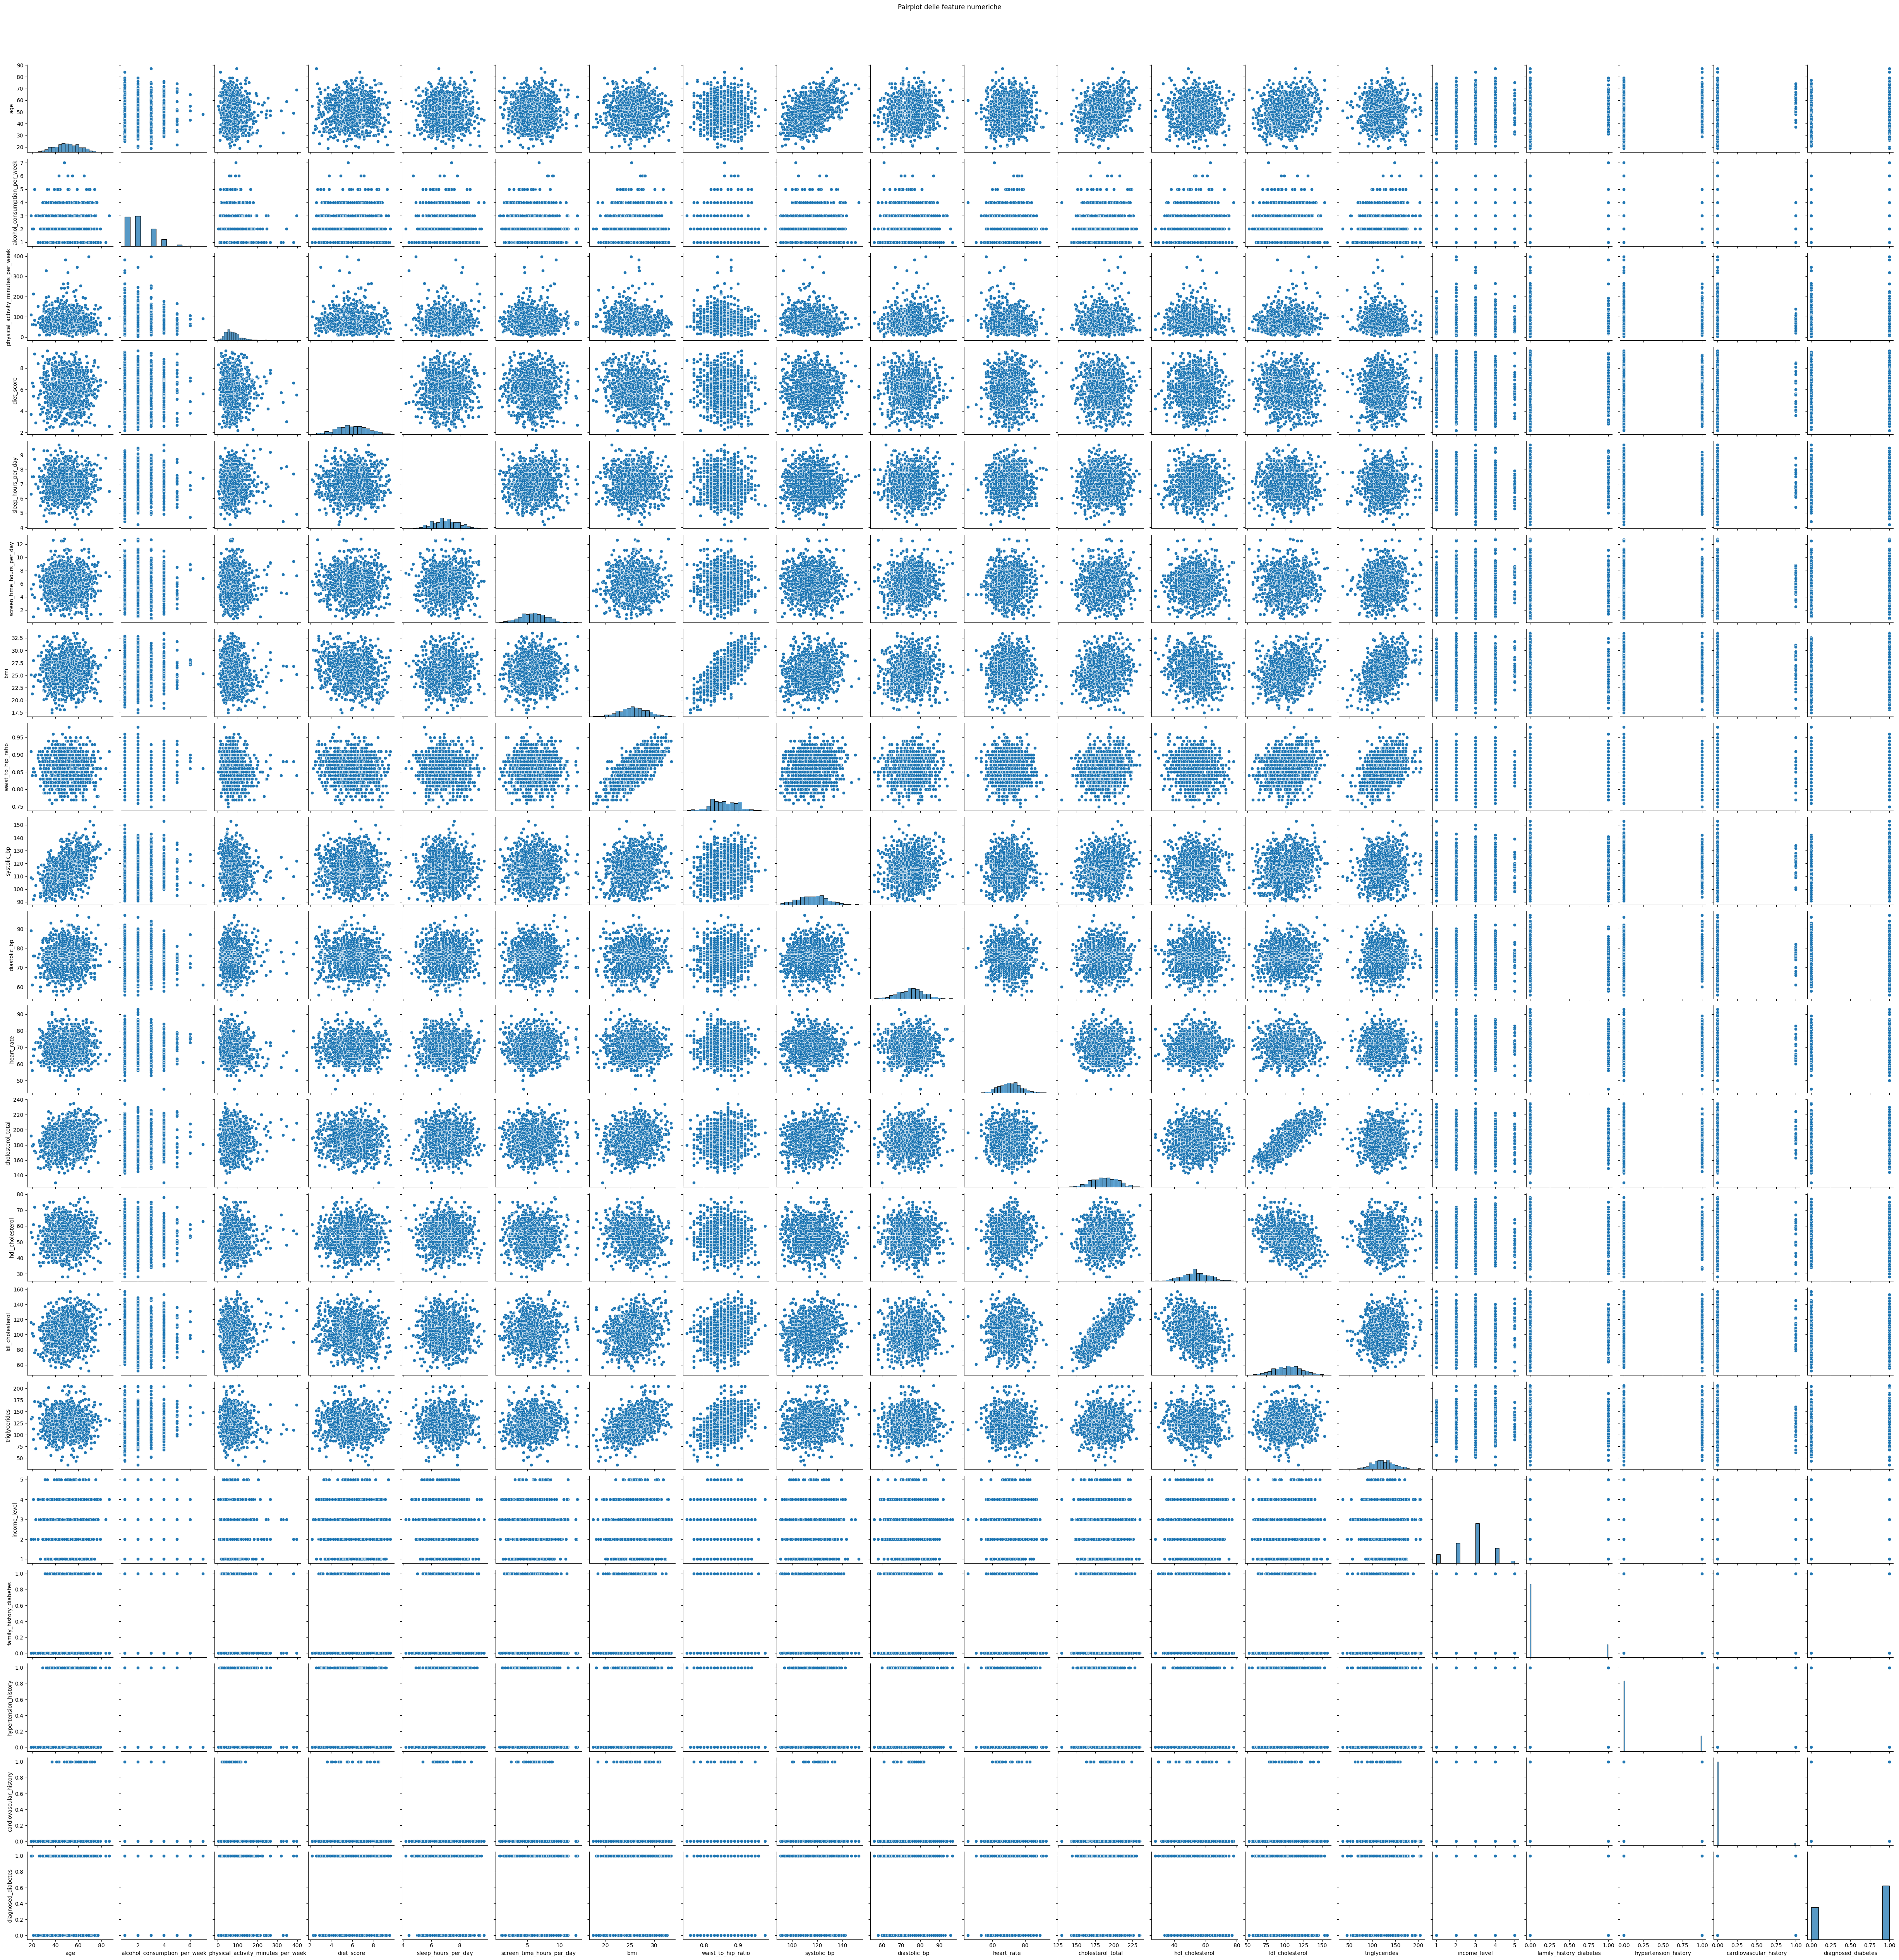

In [53]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id')  

sample_df = df[numerical_cols].sample(1000, random_state=42)

sns.pairplot(sample_df)
plt.suptitle("Pairplot delle feature numeriche", y=1.02)
plt.show()

In [54]:
print("Informazioni sul dataset:")
df.info()


Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 35 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  

Matrice di correlazione numerica:


age  alcohol_consumption_per_week  \
age                                 1.000000                      0.003295   
alcohol_consumption_per_week        0.003295                      1.000000   
physical_activity_minutes_per_week -0.029101                      0.003010   
diet_score                         -0.001898                      0.003284   
sleep_hours_per_day                -0.001286                     -0.000351   
screen_time_hours_per_day          -0.002313                      0.004797   
bmi                                 0.062958                     -0.017552   
waist_to_hip_ratio                  0.044654                     -0.014716   
systolic_bp                         0.502894                     -0.006472   
diastolic_bp                        0.188403                     -0.001502   
heart_rate                          0.004294                      0.002230   
cholesterol_total                   0.283155                     -0.003121   
hdl_cholesterol                     0.002654                      0.009062   
ldl_cholesterol                     0.245503                     -0.006305   
triglycerides                       0.043605                      0.099985   
income_level                       -0.005889                     -0.000385   
family_history_diabetes             0.018417                      0.002069   
hypertension_history                0.177636                     -0.003983   
cardiovascular_history              0.099604                     -0.001566   
diagnosed_diabetes                  0.161162                      0.002991   

                                    physical_activity_minutes_per_week  \
age                                                          -0.029101   
alcohol_consumption_per_week                                  0.003010   
physical_activity_minutes_per_week                            1.000000   
diet_score                                                    0.008466   
sleep_hours_per_day                                          -0.006900   
screen_time_hours_per_day                                     0.001754   
bmi                                                          -0.085086   
waist_to_hip_ratio                                           -0.067508   
systolic_bp                                                  -0.030908   
diastolic_bp                                                 -0.018341   
heart_rate                                                   -0.268426   
cholesterol_total                                            -0.027439   
hdl_cholesterol                                               0.015996   
ldl_cholesterol                                              -0.033272   
triglycerides                                                -0.045595   
income_level                                                  0.003722   
family_history_diabetes                                      -0.035260   
hypertension_history                                         -0.005766   
cardiovascular_history                                       -0.002205   
diagnosed_diabetes                                           -0.169789   

                                    diet_score  sleep_hours_per_day  \
age                                  -0.001898            -0.001286   
alcohol_consumption_per_week          0.003284            -0.000351   
physical_activity_minutes_per_week    0.008466            -0.006900   
diet_score                            1.000000             0.000882   
sleep_hours_per_day                   0.000882             1.000000   
screen_time_hours_per_day             0.000382             0.005965   
bmi                                  -0.198899             0.003380   
waist_to_hip_ratio                   -0.150906             0.000371   
systolic_bp                          -0.038676             0.003995   
diastolic_bp                         -0.028384             0.001457   
heart_rate                            0.005116             0.00971

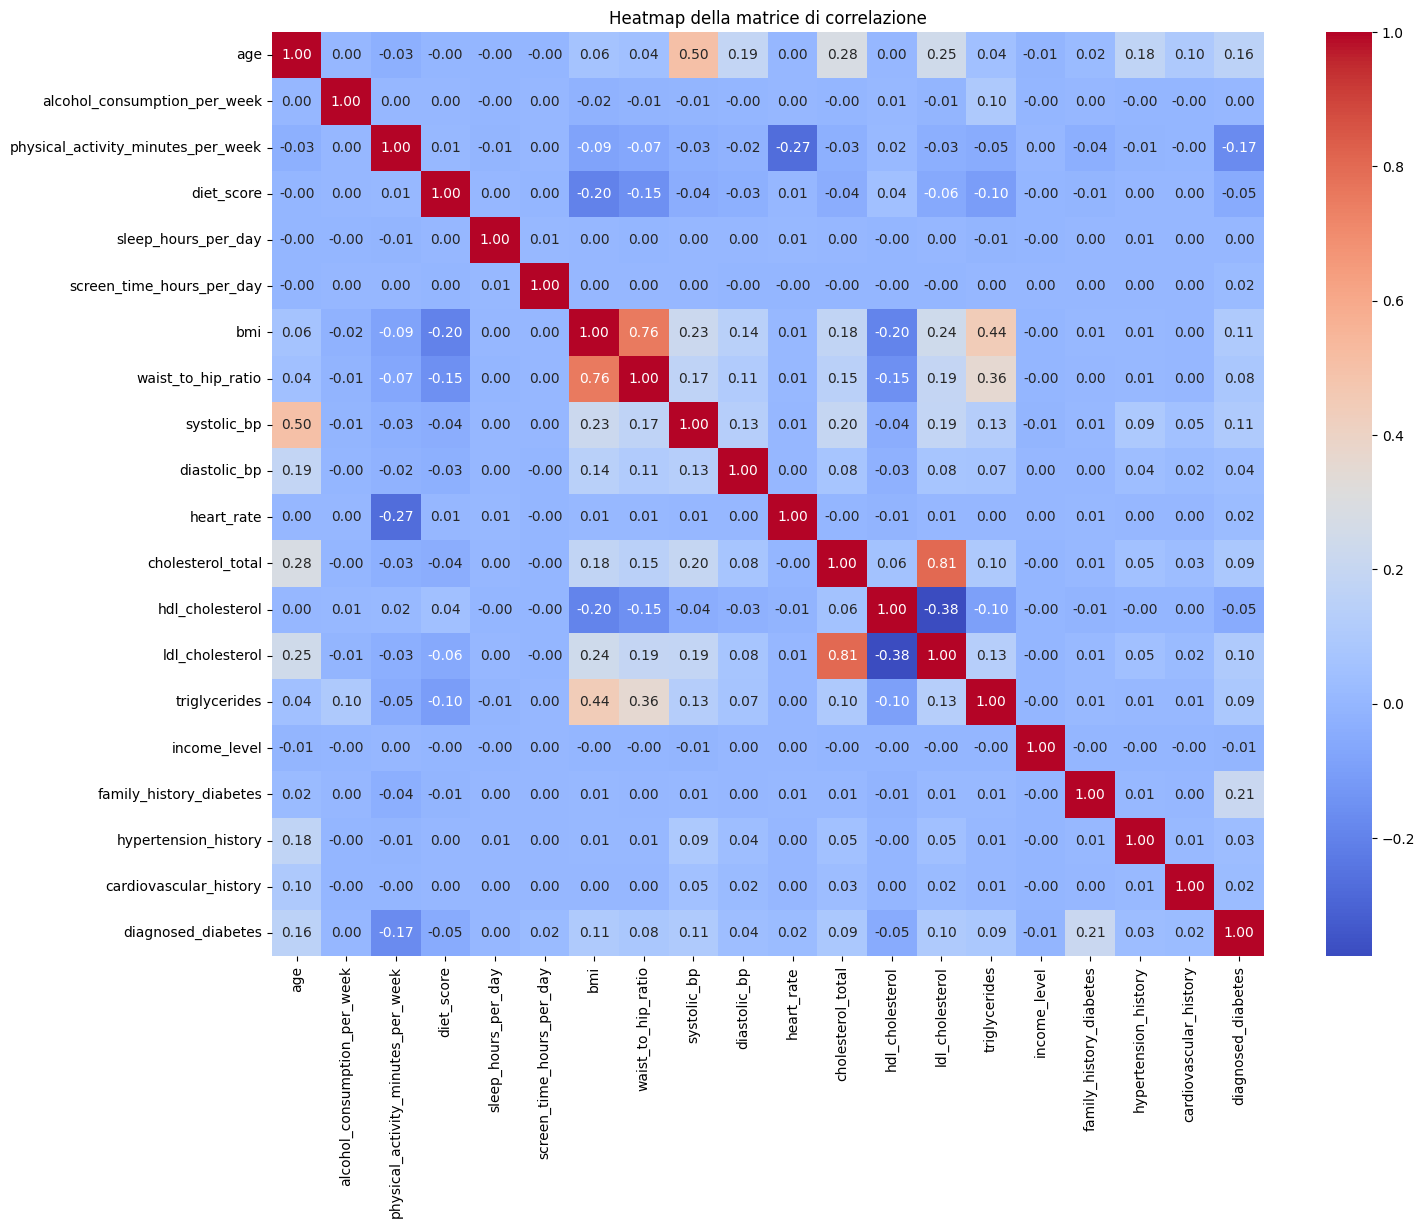

In [55]:

# Selezioniamo solo le feature numeriche
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id')  # id non serve

# Matrice di correlazione
corr_matrix = df[numerical_cols].corr()

# Stampiamo i valori della correlazione
print("Matrice di correlazione numerica:")
display(corr_matrix)

# Heatmap della correlazione
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap della matrice di correlazione")
plt.show()



In [56]:
df.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'income_level', 'family_history_diabetes',
       'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes',
       'gender_Male', 'gender_Other', 'ethnicity_Black', 'ethnicity_Hispanic',
       'ethnicity_Other', 'ethnicity_White', 'education_level_Highschool',
       'education_level_No formal', 'education_level_Postgraduate',
       'smoking_status_Former', 'smoking_status_Never',
       'employment_status_Retired', 'employment_status_Student',
       'employment_status_Unemployed'],
      dtype='object')

In [57]:
def corr_with_target(df, target_col):
    """
    Calcola la correlazione di tutte le feature numeriche con il target
    e restituisce un dataframe ordinato per valore assoluto decrescente.
    """
    # Seleziona colonne numeriche
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Rimuovi l'id se presente
    if 'id' in numerical_cols:
        numerical_cols.remove('id')
    
    # Calcola correlazione con il target
    corr_target = df[numerical_cols].corr()[target_col]
    
    # Ordina per valore assoluto decrescente
    corr_target_sorted = corr_target.reindex(corr_target.abs().sort_values(ascending=False).index)
    
    return corr_target_sorted

# Esempio d'uso
corr_sorted = corr_with_target(df, 'diagnosed_diabetes')
print(corr_sorted)


diagnosed_diabetes                    1.000000
family_history_diabetes               0.211064
physical_activity_minutes_per_week   -0.169789
age                                   0.161162
systolic_bp                           0.107132
bmi                                   0.105580
ldl_cholesterol                       0.102771
triglycerides                         0.090635
cholesterol_total                     0.088112
waist_to_hip_ratio                    0.081050
hdl_cholesterol                      -0.053231
diet_score                           -0.050119
diastolic_bp                          0.036271
hypertension_history                  0.029979
cardiovascular_history                0.024746
heart_rate                            0.023865
screen_time_hours_per_day             0.018213
income_level                         -0.006627
sleep_hours_per_day                   0.003509
alcohol_consumption_per_week          0.002991
Name: diagnosed_diabetes, dtype: float64


## Feature Engineering

In [64]:
def generate_interactive_features(df):
    df['TG_to_HDL_Ratio'] = np.where(df['hdl_cholesterol'] > 0, 
                                     df['triglycerides'] / df['hdl_cholesterol'], np.nan)
    df['income_per_age'] = df['income_level'] / df['age']
    df['alcohol_to_bmi'] = df['alcohol_consumption_per_week'] * df['bmi']
    df['alcohol_to_diet_score'] = df['alcohol_consumption_per_week'] / (df['diet_score'] + 1e-6)
    df['activity_to_bmi'] = df['physical_activity_minutes_per_week'] / df['bmi']
    df['bp_pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']
    df['cholesterol_total_to_hdl'] = np.where(df['hdl_cholesterol'] > 0, 
                                              df['cholesterol_total'] / df['hdl_cholesterol'], np.nan)
    df['screen_time_to_activity'] = df['screen_time_hours_per_day'] / (df['physical_activity_minutes_per_week'] + 1e-6)
    df['income_to_activity'] = df['income_level'] * df['physical_activity_minutes_per_week']
    return df

def generate_clinical_binary_features(df):
    is_male = df['gender_Male'] == 1
    is_female = (df['gender_Male'] == 0) & (df['gender_Other'] == 0)
    is_other = df['gender_Other'] == 1
    
    # Obesità addominale
    df['RISK_Abdominal_Obesity'] = False
    df.loc[is_male | is_other, 'RISK_Abdominal_Obesity'] = df.loc[is_male | is_other, 'waist_to_hip_ratio'] >= 1.0
    df.loc[is_female, 'RISK_Abdominal_Obesity'] = df.loc[is_female, 'waist_to_hip_ratio'] >= 0.85
    
    # Trigliceridi alti
    df['RISK_High_Triglycerides'] = df['triglycerides'] >= 150
    
    # HDL basso
    df['RISK_Low_HDL'] = False
    df.loc[is_male | is_other, 'RISK_Low_HDL'] = df.loc[is_male | is_other, 'hdl_cholesterol'] < 40
    df.loc[is_female, 'RISK_Low_HDL'] = df.loc[is_female, 'hdl_cholesterol'] < 50
    
    # Ipertensione
    df['RISK_Hypertensive_Status'] = (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 85)
    
    # Metabolic risk count
    df['Metabolic_Risk_Count'] = (
        df['RISK_Abdominal_Obesity'].astype(int) +
        df['RISK_High_Triglycerides'].astype(int) +
        df['RISK_Low_HDL'].astype(int) +
        df['RISK_Hypertensive_Status'].astype(int)
    )
    return df

df = generate_interactive_features(df)
df = generate_clinical_binary_features(df)


In [65]:
target_col = 'diagnosed_diabetes'
X = df.drop(columns=['id', target_col])
y = df[target_col]

# Split train-validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [61]:
# Contare il numero di righe dove la colonna 'gender_Other' è True (o 1)
count_other = df['gender_Other'].sum()

# Stampare il risultato
print(f"Il numero di partecipanti classificati come 'Other' è: {count_other}")

Il numero di partecipanti classificati come 'Other' è: 3678


In [66]:
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor_raw = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

In [67]:
def objective_raw(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',  # CPU-safe
        'n_jobs': -1,
        'random_state': 42
    }
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_raw),
        ('classifier', xgb.XGBClassifier(**params, use_label_encoder=False))
    ])
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    return scores.mean()

In [69]:
study_raw = optuna.create_study(direction='maximize')
study_raw.optimize(objective_raw, n_trials=10, show_progress_bar=True)

print(f"\nBest CV AUC: {study_raw.best_value:.4f}")
print("Best params:", study_raw.best_params)

[I 2025-12-05 16:55:18,862] A new study created in memory with name: no-name-e71df616-a0c4-40db-b00a-d4039dd5f819
  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:55:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:55:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, 

[I 2025-12-05 16:55:40,274] Trial 0 finished with value: 0.7135603775174385 and parameters: {'n_estimators': 441, 'learning_rate': 0.12128436810056967, 'max_depth': 8, 'subsample': 0.6812688099540052, 'colsample_bytree': 0.7072646701282197, 'gamma': 1.0455009613999744, 'reg_alpha': 0.00032578110652494314, 'reg_lambda': 0.23630680918669564}. Best is trial 0 with value: 0.7135603775174385.


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:55:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 1. Best value: 0.723365:  20%|██        | 2/10 [00:41<02:46, 20.84s/it]

[I 2025-12-05 16:56:00,716] Trial 1 finished with value: 0.7233654840197316 and parameters: {'n_estimators': 596, 'learning_rate': 0.09508719396467871, 'max_depth': 5, 'subsample': 0.67207174466789, 'colsample_bytree': 0.9029031704170902, 'gamma': 3.960319500497666, 'reg_alpha': 2.5027114356873586e-06, 'reg_lambda': 0.6148563594626333}. Best is trial 1 with value: 0.7233654840197316.


c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:56:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:56:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Best trial: 1. Best value: 0.723365:  20%|██        | 2/10 [00:54<03:36, 27.10s/it]


[W 2025-12-05 16:56:13,038] Trial 2 failed with parameters: {'n_estimators': 580, 'learning_rate': 0.05534820441524961, 'max_depth': 4, 'subsample': 0.7785846294338286, 'colsample_bytree': 0.6355037776436033, 'gamma': 3.4133329857338808, 'reg_alpha': 3.3832675172806634e-08, 'reg_lambda': 2.8300796162653402e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Rosy\AppData\Local\Temp\ipykernel_15460\4028219455.py", line 24, in objective_raw
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Rosy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 218, in wr

KeyboardInterrupt: 

In [ ]:
best_params_raw = study_raw.best_params
final_pipeline_raw = Pipeline(steps=[
    ('preprocessor', preprocessor_raw),
    ('model', xgb.XGBClassifier(
        **best_params_raw,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        use_label_encoder=False,
        tree_method='hist'
    ))
])

final_pipeline_raw.fit(X_train, y_train)

# ==============================